In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 设置字体为宋体
plt.rcParams['font.sans-serif'] = ['SimSun']  # 使用宋体
plt.rcParams['axes.unicode_minus'] = False    # 正常显示负号

In [3]:
# 从Excel读取数据
file_path = 'data.xlsm'  # 请根据实际文件路径修改
data = pd.read_excel(file_path)
print(data)


     出生  本科 最高学历 首次工作 目前工作
0    江苏  北京   北京   安徽   安徽
1    福建  陕西   陕西   湖南   湖南
2    甘肃  吉林   辽宁   吉林   辽宁
3    北京  北京   北京   北京   北京
4    湖北  湖南   湖南   湖南   湖南
..   ..  ..  ...  ...  ...
111  江苏  江苏   北京   北京   北京
112  北京  北京  加拿大   美国   北京
113  安徽  四川   江苏   湖北   安徽
114  贵州  北京   北京   北京   北京
115  安徽  安徽   安徽   北京   北京

[116 rows x 5 columns]


In [4]:
df=data
# 计算每个阶段的出度、入度和净度
def calculate_degree(df, stage1, stage2):
    # 统计每个省的出度（从stage1到stage2的流动）
    out_degree = df[stage1].value_counts().to_dict()
    
    # 统计每个省的入度（从stage1到stage2的流动）
    in_degree = df[stage2].value_counts().to_dict()
    
    # 计算净度（出度 - 入度）
    net_degree = {key: out_degree.get(key, 0) - in_degree.get(key, 0) for key in set(out_degree) | set(in_degree)}
    
    return out_degree, in_degree, net_degree

# 计算不同阶段的流动网络的入度、出度和净度
out_degree_birth_to_undergraduate, in_degree_birth_to_undergraduate, net_degree_birth_to_undergraduate = calculate_degree(df, "出生", "本科")
out_degree_undergraduate_to_highest, in_degree_undergraduate_to_highest, net_degree_undergraduate_to_highest = calculate_degree(df, "本科", "最高学历")
out_degree_highest_to_first_job, in_degree_highest_to_first_job, net_degree_highest_to_first_job = calculate_degree(df, "最高学历", "首次工作")
out_degree_first_job_to_current, in_degree_first_job_to_current, net_degree_first_job_to_current = calculate_degree(df, "首次工作", "目前工作")


In [5]:
# 确保所有省份都是相同的长度
provinces = list(set(out_degree_birth_to_undergraduate) | set(out_degree_undergraduate_to_highest) | 
                 set(out_degree_highest_to_first_job) | set(out_degree_first_job_to_current))

# 创建表格（出生到本科阶段）
df_birth_to_undergraduate = pd.DataFrame({
    "省级行政区": provinces,
    "出生到本科出度": [out_degree_birth_to_undergraduate.get(key, 0) for key in provinces],
    "出生到本科入度": [in_degree_birth_to_undergraduate.get(key, 0) for key in provinces],
    "出生到本科净度": [net_degree_birth_to_undergraduate.get(key, 0) for key in provinces]
})

# 创建表格（本科到最高学历阶段）
df_undergraduate_to_highest = pd.DataFrame({
    "省级行政区": provinces,
    "本科到最高学历出度": [out_degree_undergraduate_to_highest.get(key, 0) for key in provinces],
    "本科到最高学历入度": [in_degree_undergraduate_to_highest.get(key, 0) for key in provinces],
    "本科到最高学历净度": [net_degree_undergraduate_to_highest.get(key, 0) for key in provinces]
})

# 创建表格（最高学历到首次工作阶段）
df_highest_to_first_job = pd.DataFrame({
    "省级行政区": provinces,
    "最高学历到首次工作出度": [out_degree_highest_to_first_job.get(key, 0) for key in provinces],
    "最高学历到首次工作入度": [in_degree_highest_to_first_job.get(key, 0) for key in provinces],
    "最高学历到首次工作净度": [net_degree_highest_to_first_job.get(key, 0) for key in provinces]
})

# 创建表格（首次工作到目前工作阶段）
df_first_job_to_current = pd.DataFrame({
    "省级行政区": provinces,
    "首次工作到目前工作出度": [out_degree_first_job_to_current.get(key, 0) for key in provinces],
    "首次工作到目前工作入度": [in_degree_first_job_to_current.get(key, 0) for key in provinces],
    "首次工作到目前工作净度": [net_degree_first_job_to_current.get(key, 0) for key in provinces]
})


In [6]:
# 保存到Excel文件
with pd.ExcelWriter('人才流动网络.xlsx', engine='xlsxwriter') as writer:
    df_birth_to_undergraduate.to_excel(writer, sheet_name='出生到本科', index=False)
    df_undergraduate_to_highest.to_excel(writer, sheet_name='本科到最高学历', index=False)
    df_highest_to_first_job.to_excel(writer, sheet_name='最高学历到首次工作', index=False)
    df_first_job_to_current.to_excel(writer, sheet_name='首次工作到目前工作', index=False)

print("数据已成功保存到 '人才流动网络.xlsx' 文件中。")

数据已成功保存到 '人才流动网络.xlsx' 文件中。


In [7]:
def calculate_betweenness_custom(df, stage1, stage2):
    # 创建有向图
    G = nx.DiGraph()
    nodes = set(df[stage1]).union(set(df[stage2]))
    G.add_nodes_from(nodes)
    edges = zip(df[stage1], df[stage2])
    G.add_edges_from(edges)
    
    # 计算中介中心度
    betweenness = nx.betweenness_centrality(G, normalized=False)
    
    # 计算理论最大值（有向图）
    n = len(G.nodes())
    max_theoretical = (n - 1) * (n - 2) if n > 2 else 1  # 避免除以零
    
    # 计算相对中介中心度
    relative_betweenness = {k: v / max_theoretical for k, v in betweenness.items()}
    
    return betweenness, relative_betweenness
# def calculate_betweenness_custom(df, stage1, stage2):
#     # 创建有向图
#     G = nx.DiGraph()
    
#     # 添加节点和边
#     nodes = set(df[stage1]).union(set(df[stage2]))
#     G.add_nodes_from(nodes)
#     edges = zip(df[stage1], df[stage2])
#     G.add_edges_from(edges)
    
#     # 计算中介中心度
#     betweenness = {node: 0 for node in G.nodes()}
    
#     for node in G.nodes():
#         for j in G.nodes():
#             if node == j:
#                 continue
#             for k in G.nodes():
#                 if j != k and j < k:
#                     # 检查是否存在从 j 到 k 的路径
#                     if nx.has_path(G, j, k):
#                         paths_jk = list(nx.all_shortest_paths(G, source=j, target=k))
#                         g_jk_node = sum([node in path for path in paths_jk])
#                     else:
#                         g_jk_node = 0
                    
#                     # 检查是否存在从 node 到 k 的路径
#                     try:
#                         paths_ik = list(nx.all_shortest_paths(G, source=node, target=k))
#                         g_ik = len(paths_ik)
#                     except nx.NetworkXNoPath:
#                         g_ik = 0
                    
#                     if g_ik > 0:
#                         betweenness[node] += g_jk_node / g_ik
    
#     # 标准化
#     max_bc = max(betweenness.values()) if betweenness else 1
#     relative_betweenness = {k: v / max_bc for k, v in betweenness.items()}
    
#     return betweenness, relative_betweenness

In [8]:


# 假设 df 是包含节点流动数据的 DataFrame
# 计算不同阶段的中介中心度和相对中介中心度
betweenness_birth_to_undergraduate, relative_betweenness_birth_to_undergraduate = calculate_betweenness_custom(df, "出生", "本科")
betweenness_undergraduate_to_highest, relative_betweenness_undergraduate_to_highest = calculate_betweenness_custom(df, "本科", "最高学历")
betweenness_highest_to_first_job, relative_betweenness_highest_to_first_job = calculate_betweenness_custom(df, "最高学历", "首次工作")
betweenness_first_job_to_current, relative_betweenness_first_job_to_current = calculate_betweenness_custom(df, "首次工作", "目前工作")

# 创建包含中介中心度和相对中介中心度的表格
df_birth_to_undergraduate = pd.DataFrame({
    "省级行政区": list(set(betweenness_birth_to_undergraduate) | set(relative_betweenness_birth_to_undergraduate)),
    "出生到本科中介中心度": [betweenness_birth_to_undergraduate.get(key, 0) for key in list(set(betweenness_birth_to_undergraduate) | set(relative_betweenness_birth_to_undergraduate))],
    "出生到本科相对中介中心度": [relative_betweenness_birth_to_undergraduate.get(key, 0) for key in list(set(betweenness_birth_to_undergraduate) | set(relative_betweenness_birth_to_undergraduate))],
})

df_undergraduate_to_highest = pd.DataFrame({
    "省级行政区": list(set(betweenness_undergraduate_to_highest) | set(relative_betweenness_undergraduate_to_highest)),
    "本科到最高学历中介中心度": [betweenness_undergraduate_to_highest.get(key, 0) for key in list(set(betweenness_undergraduate_to_highest) | set(relative_betweenness_undergraduate_to_highest))],
    "本科到最高学历相对中介中心度": [relative_betweenness_undergraduate_to_highest.get(key, 0) for key in list(set(betweenness_undergraduate_to_highest) | set(relative_betweenness_undergraduate_to_highest))],
})

df_highest_to_first_job = pd.DataFrame({
    "省级行政区": list(set(betweenness_highest_to_first_job) | set(relative_betweenness_highest_to_first_job)),
    "最高学历到首次工作中介中心度": [betweenness_highest_to_first_job.get(key, 0) for key in list(set(betweenness_highest_to_first_job) | set(relative_betweenness_highest_to_first_job))],
    "最高学历到首次工作相对中介中心度": [relative_betweenness_highest_to_first_job.get(key, 0) for key in list(set(betweenness_highest_to_first_job) | set(relative_betweenness_highest_to_first_job))],
})

df_first_job_to_current = pd.DataFrame({
    "省级行政区": list(set(betweenness_first_job_to_current) | set(relative_betweenness_first_job_to_current)),
    "首次工作到目前工作中介中心度": [betweenness_first_job_to_current.get(key, 0) for key in list(set(betweenness_first_job_to_current) | set(relative_betweenness_first_job_to_current))],
    "首次工作到目前工作相对中介中心度": [relative_betweenness_first_job_to_current.get(key, 0) for key in list(set(betweenness_first_job_to_current) | set(relative_betweenness_first_job_to_current))],
})

# 保存到Excel文件
with pd.ExcelWriter('人才流动网络_中介中心度_自定义.xlsx', engine='xlsxwriter') as writer:
    df_birth_to_undergraduate.to_excel(writer, sheet_name='出生到本科', index=False)
    df_undergraduate_to_highest.to_excel(writer, sheet_name='本科到最高学历', index=False)
    df_highest_to_first_job.to_excel(writer, sheet_name='最高学历到首次工作', index=False)
    df_first_job_to_current.to_excel(writer, sheet_name='首次工作到目前工作', index=False)

print("数据已成功保存到 '人才流动网络_中介中心度_自定义.xlsx' 文件中。")


数据已成功保存到 '人才流动网络_中介中心度_自定义.xlsx' 文件中。


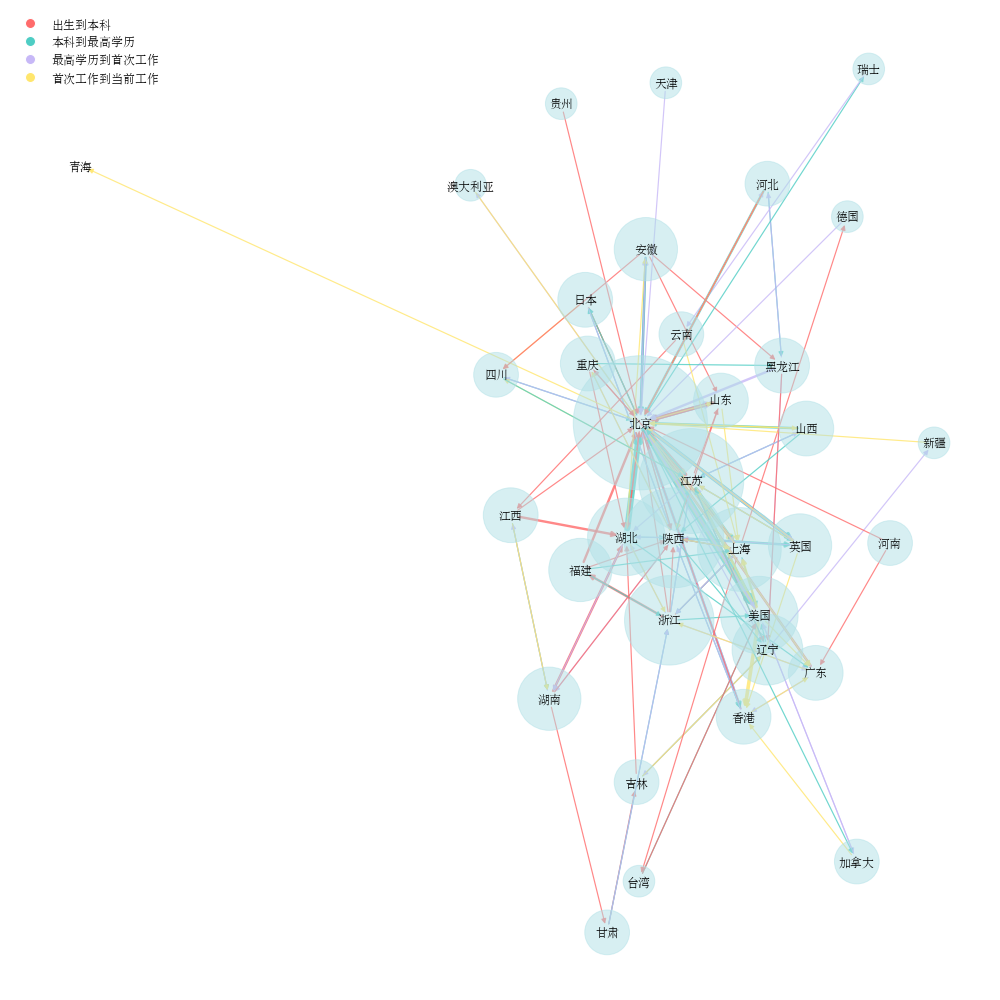

In [9]:
# 构建流动关系
edges = []

# 遍历数据，构建流动的边
for _, record in data.iterrows():
    birth, undergrad, highest_edu, first_job, current_job = record
    if birth != undergrad: edges.append(('出生到本科', birth, undergrad))
    if undergrad != highest_edu: edges.append(('本科到最高学历', undergrad, highest_edu))
    if highest_edu != first_job: edges.append(('最高学历到首次工作', highest_edu, first_job))
    if first_job != current_job: edges.append(('首次工作到当前工作', first_job, current_job))

# 统计每对地点间流动的频率
edge_counts = Counter(edges)

# 创建一个有向图
G = nx.DiGraph()

# 添加边和权重（避免自环）
for stage, node1, node2 in edge_counts:
    if node1 != node2:  # 避免自环
        weight = edge_counts[(stage, node1, node2)]  # 根据频率设置边的权重
        G.add_edge(node1, node2, weight=weight, stage=stage)

# 设置布局
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=20)  # 调整布局参数，使图形更加清晰

# 绘制图形
plt.figure(figsize=(14, 14))

# 节点样式
node_sizes = [len(list(G.neighbors(node))) * 1000 for node in G.nodes()]  # 节点大小基于邻居数
node_colors = '#B0E0E6'  # 节点颜色选择淡蓝色（浅钢蓝色），不抢眼

# 为不同阶段设置不同颜色
stage_colors = {
    '出生到本科': '#FF6B6B',  # 淡红色
    '本科到最高学历': '#4ECDC4',  # 淡绿色
    '最高学历到首次工作': '#C7B8F7',  # 淡紫色
    '首次工作到当前工作': '#FFE66D',  # 柔和黄色
}

# 绘制节点
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.5)

# 边的颜色增强，使用更深的颜色和按权重调整粗细
for (stage, node1, node2) in edge_counts:
    if node1 != node2:  # 避免自环
        weight = edge_counts[(stage, node1, node2)]  # 边的权重
        edge_width = weight * 1.2  # 按比例加大边的宽度（设置为1.2）

        # 根据不同的阶段设置边的颜色
        edge_color = stage_colors.get(stage, '#A9A9A9')  # 默认灰色

        # 绘制边，设置箭头
        nx.draw_networkx_edges(G, pos, edgelist=[(node1, node2)], 
                               edge_color=edge_color, width=edge_width, alpha=0.8, arrows=True)

# 绘制节点标签
nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold", font_color="black")

# 移除坐标轴
plt.axis("off")

# 创建一个统一的图例
handles = []
for stage, color in stage_colors.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=stage))

plt.legend(handles=handles, loc='upper left', fontsize=12, frameon=False)

# 显示图形
plt.tight_layout()  # 自动调整图形布局
plt.show()